In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4
from erddapy import ERDDAP
import json
import re

Pull in the processed inventory

In [2]:
ra = "maracoos"

#
# df_cruise = df[df['Station Description'] == 'Chesapeake Bay WQ Cruise Data ']
#
#df_aws = df[df['Station ID'] == 'Humboldt']
# #url = 'http://tds.glos.us/thredds/dodsC/buoy_agg_standard/OMOECC_E1/OMOECC_E1.ncml'
# #url = 'http://tds.glos.us/thredds/dodsC/buoy_agg_standard/45186/45186.ncml'
# #url = 'http://tds.glos.us/thredds/dodsC/buoy_agg_standard/bgsusd2/bgsusd2.ncml'
# url = 'http://oos.soest.hawaii.edu/thredds/dodsC/hioos/nss/ns12agg'
# print(url)
# ds = xr.open_dataset(url)
# #ds = netCDF4.Dataset(url,'r')
# title = ds.title
# start_time = np.datetime_as_string(ds.time.min().values, unit='D')
# end_time = np.datetime_as_string(ds.time.max().values, unit='D')
# print('Duration: %s - %s' % (np.datetime_as_string(ds.time.min().values, unit='D'),
#                              np.datetime_as_string(ds.time.max().values, unit='D'))
#       )

# Try glos web server
# url = 'https://glbuoys.glos.us/tools/export?ftype=csv&data_type=buoy&units=eng&locs=OMOECC_E1&params=Water_Temperature_at_Surface|dissolved_oxygen_saturation|water_conductivity|ysi_turbidity&tperiod=custom&date_start=2020-01-01&date_end=2020-12-31&avg_ivld=none'
# df = erddapy.ERDDAP.to_pandas(url)

## using ERDDAP to look for stations
# check out http://data.glos.us/erddap/tabledap/allDatasets.htmlTable?datasetID%2Ctitle%2CminTime%2CmaxTime&maxTime%3E=2020-01-01&maxTime%3C=2020-12-31&orderBy(%22maxTime%22)
# that lists out all the GLOS stations with the maximum time of observations within the year 2020 (on their ERDDAP).


ra_clean = re.sub(r'[0-9]', '', ra) # remove number from RA 

df = pd.read_excel('2024/data/processed/%s.xlsx' % ra_clean.upper(), dtype=str)
df.head()

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude (dec deg),Longitude (dec deg),Platform Type,"Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)","Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,"Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].",Additional notes
0,MARACOOS,Iron_Pot_Landing,N/A: No WMO numbers,Iron_Pot_Landing - Maryland DNR Station,Maryland Department of Natural Resources water...,38.796,-76.7208,fixed,2003,Y,Maryland DNR,N,Maryland DNR,gov_state,Maryland DNR,RPS-ASA,"Fractional_saturation_of_oxygen_in_sea_water, ...",NaN
1,MARACOOS,Jug_Bay,N/A: No WMO numbers,Jug_Bay - Maryland DNR Station,Maryland Department of Natural Resources water...,38.7813,-76.7137,fixed,2003,Y,Maryland DNR,N,Maryland DNR,gov_state,Maryland DNR,RPS-ASA,"Fractional_saturation_of_oxygen_in_sea_water, ...",NaN
2,MARACOOS,Mataponi,N/A: No WMO numbers,Mataponi - Maryland DNR Station,Maryland Department of Natural Resources water...,38.7433,-76.7074,fixed,2003,Y,Maryland DNR,N,Maryland DNR,gov_state,Maryland DNR,RPS-ASA,"Fractional_saturation_of_oxygen_in_sea_water, ...",NaN
3,MARACOOS,Aquarium_West,N/A: No WMO numbers,Aquarium_West - Maryland DNR Station,Maryland Department of Natural Resources water...,39.2854,-76.6088,fixed,2016,Y,Maryland DNR,N,Maryland DNR,gov_state,Maryland DNR,RPS-ASA,"Fractional_saturation_of_oxygen_in_sea_water, ...",NaN
4,MARACOOS,Aquarium_East,N/A: No WMO numbers,Aquarium_East - Maryland DNR Station,Maryland Department of Natural Resources water...,39.2855,-76.608,fixed,2016,Y,Maryland DNR,N,Maryland DNR,gov_state,Maryland DNR,RPS-ASA,"Fractional_saturation_of_oxygen_in_sea_water, ...",NaN


## Check column headers

The official column headers are found in the README at https://github.com/ioos/ioos-asset-inventory/tree/main. This checks the column headers from the RA inventory against our official column headers to see if anything is missing. The result will print out what columns are missing from the RA inventory and what columns the RA added to their inventory.

In [3]:
url = 'https://github.com/ioos/ioos-asset-inventory/tree/main'

import pandas as pd

df_fields = pd.read_html(url)#

control_fields = df_fields[2]['Field'].tolist()


def diff(a, b):
  if len(set(a) - set(b)) > 0:
    print(f"Columns missing: {set(a) - set(b)}")
  if len(set(b) - set(a)) > 0:
    print(f"Columns added: {set(b) - set(a)}")
  if set(a) == set(b):
    print(f"They are the same")

diff(control_fields, df.columns.tolist())

They are the same


Make a plot of all points.

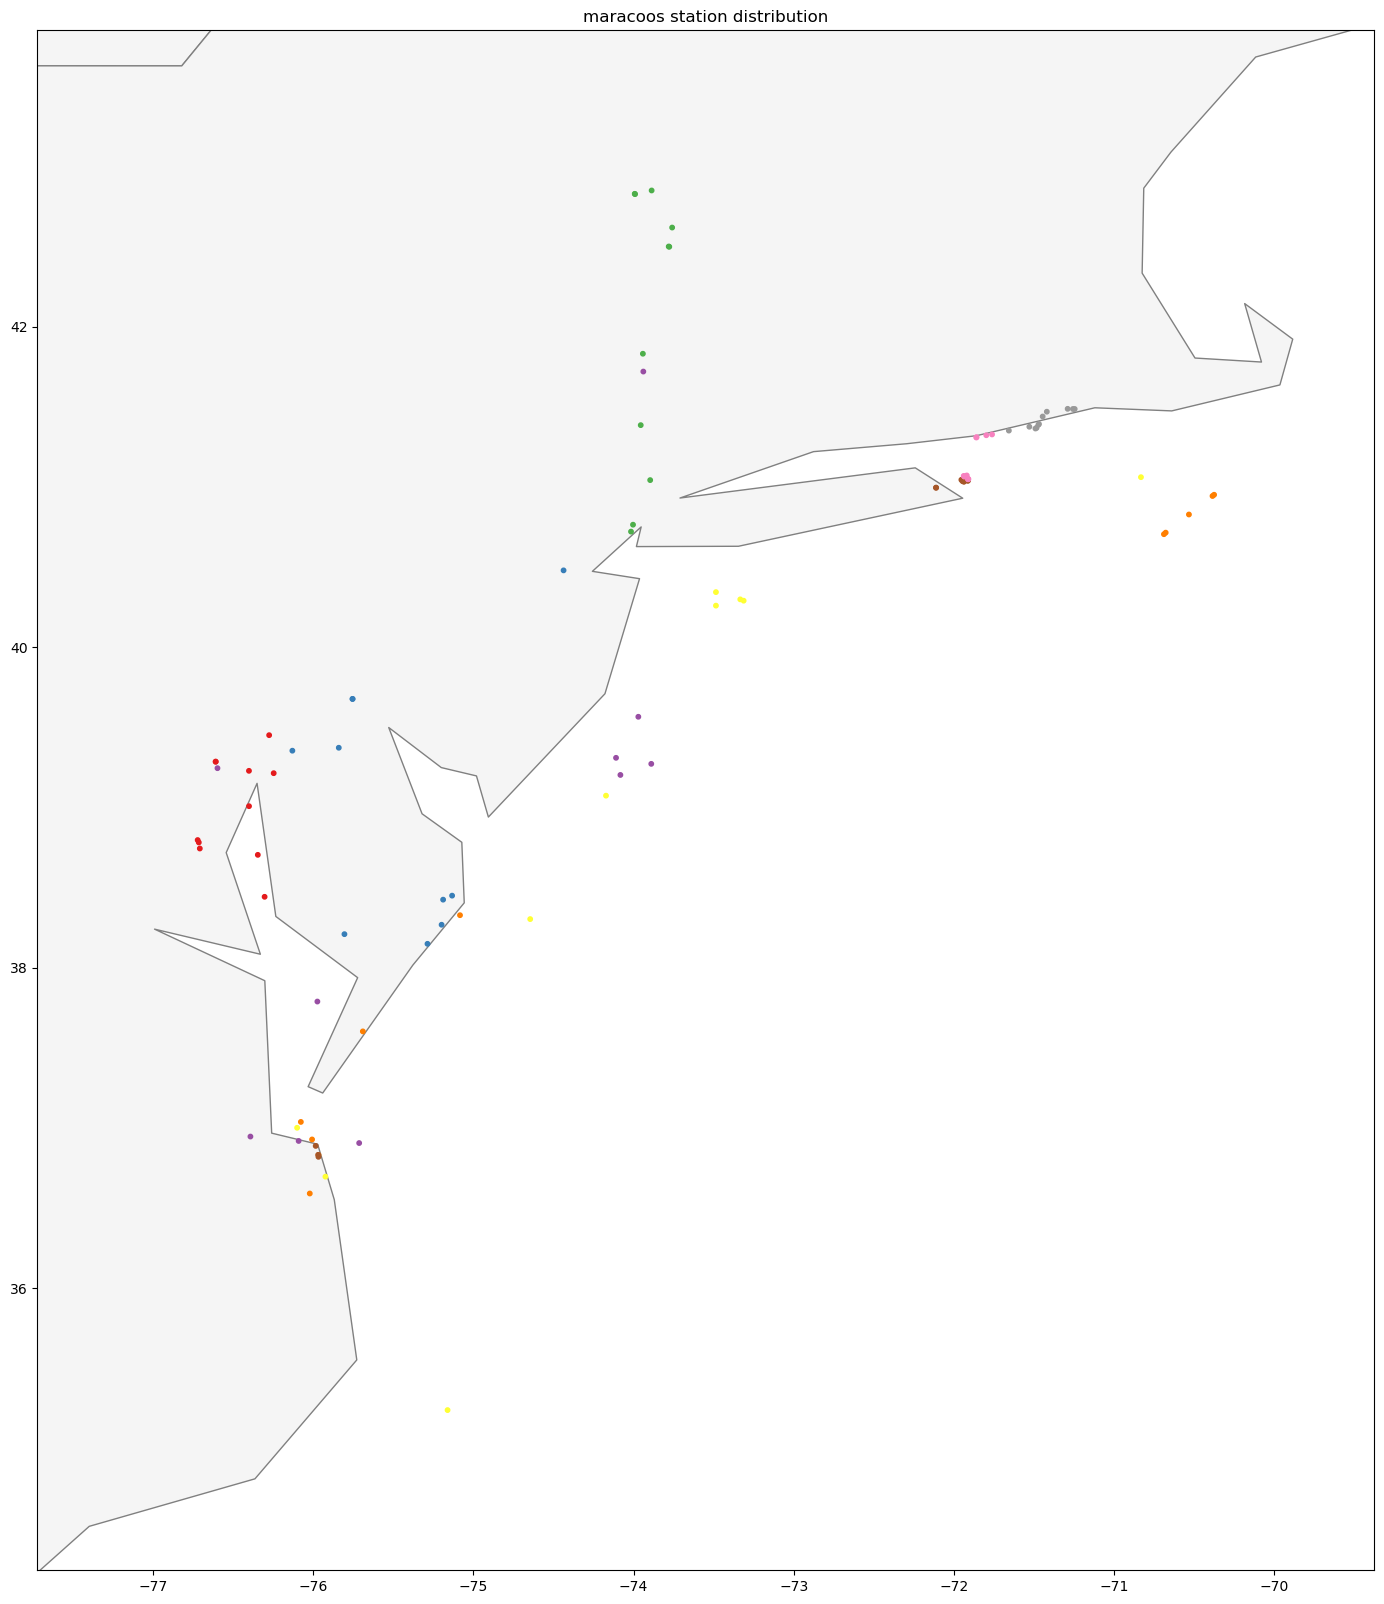

In [4]:
import geopandas
import matplotlib.pyplot as plt

#df = df.loc[df['']]

df.rename(columns=
{'Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].':
     'Variable Names',
 'Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)': 'Station Deployment',
 'Longitude (dec deg)': 'Longitude',
 'Latitude (dec deg)': 'Latitude'},
              inplace=True)

df['Station Deployment'] = \
    df['Station Deployment'].astype(str)


gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df['Longitude'], df['Latitude']))

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = world.plot(
    color='whitesmoke', 
    edgecolor='grey', 
    figsize=(25,20),
    )

gdf.plot( ax=ax,
         #column='erddap_avail', 
         categorical=True, 
         cmap = 'Set1',
         markersize=10, 
         legend=True,
         legend_kwds={'title': "ERDDAP Available?"},
         k=2,
        )



minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx-1, maxx+1)
ax.set_ylim(miny-1, maxy+1)

plt.title('{} station distribution'.format(ra))

plt.show()

Make an interactive map.

When you click on a point the return is the information from the inventory.

In [5]:
gdf_final = gdf.set_crs(epsg=4326)

gdf_final.loc[~gdf_final['geometry'].is_empty == True].drop(columns='Variable Names').explore()#'erddap_avail',cmap = 'Set1')


Configure the ERDDAP to search

In [6]:
with open('utils/ra_erddaps.json') as f:
    urls = json.load(f)

server = urls[ra.lower()]

print(server)

e = ERDDAP(server=server, protocol="tabledap")

https://erddap.maracoos.org/erddap


Search the ERDDAP server for a single station of interest - more of a test

In [7]:
# df['Station ID'].loc[df['Station ID'].isna()] = df.loc[df['Station ID'].isna(),'Dataset ID']

# df['Station ID']

In [8]:
# df_wf = df[df['Station ID'] == 'Jug_Bay']

# # for SCCOOS need to search for 'Station Long Name' as 'Station ID' is NA for most entries
# search_for = df_wf['Station ID'].to_string()

# search_url = e.get_search_url(search_for=search_for, response="csv")

# try:
#     resp = pd.read_csv(search_url)
#     print(resp['Station ID'])
# except:
#     pass

Rip through all the datasets in the inventory and see if they exist on the RA erddap. Process checks the following order:

1. `Station ID`, then 
2. `Station Long Name`, then
3. `WMO ID or NWS/CMAN ID`

We first check if the value is `nan`. If so, we punt as that will return all datasets from the ERDDAP service.

In [9]:
not_found = []
found = dict()

exclude = ' -gliders'


if ra == 'glos':
    search_order = ['Dataset (ERDDAP) ID','Station ID', 'Station Long Name']
elif ra == 'sccoos':
    search_order = ['Station Long Name', 'WMO ID or NWS/CMAN ID', 'Station Description']
else:
    search_order = ['Station ID', 'Station Long Name', 'WMO ID or NWS/CMAN ID']

# GLOS
#search_order = ['Dataset (ERDDAP) ID','Station ID', 'Station Long Name']
# SCCOOS
#search_order = ['Station Long Name', 'WMO ID or NWS/CMAN ID', 'Station Description']

for search1 in df[search_order[0]].astype(str):

    if search1 == "nan":
        print("punting with %s = nan\n" % search_order[0])
        not_found.append(search1)
        continue
    
    try:
        print('searching \"%s\" = \"%s\"' % (search_order[0], search1))
        search_url = e.get_search_url(search_for=search1+exclude, response="csv")
        resp = pd.read_csv(search_url)
        
        print("Found \"%s\": %s" % (search1,resp['Dataset ID'].values.tolist()))
        
        for dset_id in resp['Dataset ID'].values.tolist():
            if search1.lower() in dset_id.lower():
                found[search1] = {'Dataset ID': [dset_id]}
                print("Keeping \"%s\": %s" % (search1,dset_id))
                #found[search1] = {'Dataset ID': resp['Dataset ID'].values.tolist()}
        
    except:
        
        print('no dataset matching \"%s\"' % search1)
        search2 = df.loc[df[search_order[0]] == search1, search_order[1]].values.tolist()[0]
        
        if search2 == "nan":
                print("punting with %s = nan\n" % search_order[1])
                not_found.append(search1)
                continue
                
        try:
            
            print('searching \"%s\" = \"%s\"' % (search_order[1], search2))
            search_url = e.get_search_url(search_for=search2+exclude, response="csv")
            resp = pd.read_csv(search_url)
            print("Found \"%s\": %s" % (search2,resp['Dataset ID'].values.tolist()))
            
            found[search1] = {'Dataset ID': resp['Dataset ID'].values.tolist()}
            
        except:

            search3 = str(df.loc[df[search_order[0]] == search1, search_order[2]].values.tolist()[0])
            
            if search3 == "nan":
                print("punting with \"%s\" = nan\n" % search_order[2])
                not_found.append(search1)
                continue
            
            try:
                print('searching \"%s\" = \"%s\"' % (search_order[2], search3))
                search_url = e.get_search_url(search_for=search3+exclude, response="csv")
                resp = pd.read_csv(search_url)
                print("Found \"%s\": %s" % (search3,resp['Dataset ID'].values.tolist()))
                
                found[search1] = {'Dataset ID': resp['Dataset ID'].values.tolist()}
                
            except:
                print("Couldn't find:", [search1, search2, search3])
                not_found.append(search1)
        
    print("\n")

searching "Station ID" = "Iron_Pot_Landing"
Found "Iron_Pot_Landing": ['mddnr_Iron_Pot_Landing']
Keeping "Iron_Pot_Landing": mddnr_Iron_Pot_Landing


searching "Station ID" = "Jug_Bay"
Found "Jug_Bay": ['mddnr_Jug_Bay']
Keeping "Jug_Bay": mddnr_Jug_Bay


searching "Station ID" = "Mataponi"
Found "Mataponi": ['mddnr_Mataponi']
Keeping "Mataponi": mddnr_Mataponi


searching "Station ID" = "Aquarium_West"
Found "Aquarium_West": ['mddnr_Aquarium_West']
Keeping "Aquarium_West": mddnr_Aquarium_West


searching "Station ID" = "Aquarium_East"
Found "Aquarium_East": ['mddnr_Aquarium_East_-_Bottom', 'mddnr_Aquarium_East_-_Surface']
Keeping "Aquarium_East": mddnr_Aquarium_East_-_Bottom
Keeping "Aquarium_East": mddnr_Aquarium_East_-_Surface


searching "Station ID" = "Pleasure_Island"
Found "Pleasure_Island": ['mddnr_Pleasure_Island']
Keeping "Pleasure_Island": mddnr_Pleasure_Island


searching "Station ID" = "Sandy_Pt_South_Beach"
no dataset matching "Sandy_Pt_South_Beach"
searching "Station Long

Print the stations that we couldn't find.

In [10]:
len(not_found)

28

In [11]:
len(found)

48

Show me the record that has NaN for the first search element.

In [12]:
df.loc[df[search_order[0]].isna()]

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude,Longitude,Platform Type,Station Deployment,"Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,Variable Names,Additional notes,geometry


Now show me the stations, with identifiers, that we couldn't find.

In [13]:
df[df[search_order[0]].isin(not_found)]

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude,Longitude,Platform Type,Station Deployment,"Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,Variable Names,Additional notes,geometry
6,MARACOOS,Sandy_Pt_South_Beach,N/A: No WMO numbers,Sandy_Pt_South_Beach - Maryland DNR Station,Maryland Department of Natural Resources water...,39.0075,-76.4003,fixed,2004,Y,Maryland DNR,N,Maryland DNR,gov_state,Maryland DNR,RPS-ASA,"Fractional_saturation_of_oxygen_in_sea_water, ...",NaN,POINT (-76.40030 39.00750)
7,MARACOOS,Tinghman_Island,N/A: No WMO numbers,Tinghman_Island - Maryland DNR Station,Maryland Department of Natural Resources water...,38.7037,-76.3453,fixed,2017,Y,Maryland DNR,N,Maryland DNR,gov_state,Maryland DNR,RPS-ASA,"Fractional_saturation_of_oxygen_in_sea_water, ...",NaN,POINT (-76.34530 38.70370)
14,MARACOOS,UD 3.7M GEO DISH,N/A: No WMO numbers,UDel Geostationary Satellite ground Station,Geostationary Satellite Ground Station,39.677,-75.754,fixed_satellite,2013,Y,"MARACOOS, Udelaware",Yp,Univ. Delaware,ACADEMIC,Univ. Delaware,RPS-ASA,All Standard GOES products,NaN,POINT (-75.75400 39.67700)
15,MARACOOS,UD 2.4M POLAR DISH,N/A: No WMO numbers,UDel Dual X/L Band Satellite ground Station,X/L-band Satellite Ground Station,39.677,-75.754,fixed_satellite,2010,Y,"MARACOOS, Udelaware",Yp,Univ. Delaware,ACADEMIC,Univ. Delaware,RPS-ASA,"Satellite Imagery from AVHRR, MODIS, VIIRS (SS...",NaN,POINT (-75.75400 39.67700)
20,MARACOOS,RU X/L-band,N/A: No WMO numbers,Rutgers Dual X/L Band Satellite ground Station,X/L-band Satellite Ground Station,40.4795,-74.4367,fixed_satellite,2003,Y,"MARACOOS, Rutgers",Yp,Rutgers,ACADEMIC,Rutgers,RPS-ASA,"Satellite Imagery from AVHRR, MODIS, VIIRS (SS...",NaN,POINT (-74.43670 40.47950)
21,MARACOOS,Pier_26,N/A: No WMO numbers,Pier 26 Weather/Hydro Station - HRECOS,Hudson River Environmental Conditions Observin...,40.721538,-74.0156,fixed,2016,Y,Hudson River Environmental Conditions Observin...,N,Hudson River Environmental Conditions Observin...,nonprofit,Hudson River Environmental Conditions Observin...,RPS-ASA,"air_pressure, air_temperature, dew_point_tempe...",NaN,POINT (-74.01560 40.72154)
22,MARACOOS,Pier_84,N/A: No WMO numbers,Pier_84 Hydro/weather Station - HRECOS,Hudson River Environmental Conditions Observin...,40.764628,-74.003186,fixed,2012,Y,Hudson River Environmental Conditions Observin...,N,Hudson River Environmental Conditions Observin...,nonprofit,Hudson River Environmental Conditions Observin...,RPS-ASA,"air_pressure, air_temperature, dew_point_tempe...",NaN,POINT (-74.00319 40.76463)
23,MARACOOS,Mowhawk R. Lock 8 weather,N/A: No WMO numbers,Port of Albany hydro/weather station - HRECOS,Hudson River Environmental Conditions Observin...,42.8302,-73.9925,fixed,2012,Y,Hudson River Environmental Conditions Observin...,N,Hudson River Environmental Conditions Observin...,nonprofit,Hudson River Environmental Conditions Observin...,RPS-ASA,"air_pressure, air_temperature, dew_point_tempe...",NaN,POINT (-73.99250 42.83020)
24,MARACOOS,Mowhawk R. Lock 8 hydro,N/A: No WMO numbers,Mowhawk R. Lock 8 Hydrologic station - HRECOS,Hudson River Environmental Conditions Observin...,42.8281,-73.9904,fixed,2012,Y,Hudson River Environmental Conditions Observin...,N,Hudson River Environmental Conditions Observin...,nonprofit,Hudson River Environmental Conditions Observin...,RPS-ASA,"dissolved_oxygen_saturation, dissolved_oxygen,...",NaN,POINT (-73.99040 42.82810)
26,MARACOOS,Norrie Point,N/A: No WMO numbers,Norrie Point hydro/weather station - HRECOS,Hudson River Environmental Conditions Observin...,41.831876,-73.941606,fixed,2008,Y,Hudson River Environmental Conditions Observin...,N,Hudson River Environmental Conditions Observin...,nonprofit,Hudson River Environmental Conditions Observin...,RPS-ASA,"air_pressure, air_temperature, dew_point_tempe...",NaN,POINT (

Print out all the dataset IDs for the datasets that matched our criteria.

In [14]:
found

{'Iron_Pot_Landing': {'Dataset ID': ['mddnr_Iron_Pot_Landing']},
 'Jug_Bay': {'Dataset ID': ['mddnr_Jug_Bay']},
 'Mataponi': {'Dataset ID': ['mddnr_Mataponi']},
 'Aquarium_West': {'Dataset ID': ['mddnr_Aquarium_West']},
 'Aquarium_East': {'Dataset ID': ['mddnr_Aquarium_East_-_Surface']},
 'Pleasure_Island': {'Dataset ID': ['mddnr_Pleasure_Island']},
 'Taylors_Island': {'Dataset ID': ['mddnr_Taylors_Island']},
 'Otter_Point_Creek': {'Dataset ID': ['mddnr_Otter_Point_Creek']},
 'Tolchester': {'Dataset ID': ['mddnr_Tolchester']},
 'Camp_Tockwogh': {'Dataset ID': ['mddnr_Camp_Tockwogh']},
 'Budds_Landing': {'Dataset ID': ['mddnr_Budds_Landing']},
 'Little_Monie_Creek': {'Dataset ID': ['mddnr_Little_Monie_Creek']},
 'Public_Landing': {'Dataset ID': ['mddnr_Public_Landing']},
 'Newport_Creek': {'Dataset ID': ['mddnr_Newport_Creek']},
 'Bishopville_Prong': {'Dataset ID': ['mddnr_Bishopville_Prong']},
 'Greys_Creek': {'Dataset ID': ['mddnr_Greys_Creek']},
 'Masonville_Cove_Pier': {'Dataset ID'

Check if each found dataset has coverage for specified CY

In [15]:
valid_datasets = []

cy = '2024'

for key in found:
    
    print(f'testing {key}')
    
    dataset_id = found[key]['Dataset ID'] #+" "+found[key]['Station ID']
    
    if len(dataset_id)>1:
        
        for dataset in dataset_id:
            
            e.dataset_id = dataset
    
            e.constraints = {
                 "time>=": "{}-01-01".format(cy)
            }
        
            e.variables = ['time']
    
            try:
                df_data = e.to_pandas(parse_dates=True)
                valid_datasets.extend([key])
                
            except:

                print(f'No data for {cy} for {key}: dataset ID {e.dataset_id}')# % (key,e.dataset_id))

                pass

                

    else:
        
        e.dataset_id = dataset_id[0]
    
        e.constraints = {
                         "time>=": "{}-01-01".format(cy)
                        }
        
        e.variables = ['time']
        
        try:
            
            df_data = e.to_pandas(parse_dates=True)

            valid_datasets.extend([key])

        except:

            print(f'No data for {cy} for {key}: dataset ID {e.dataset_id}')# % (key,e.dataset_id))
            
            pass

            #print("No data for 2021 for %s: dataset ID %s" % (key,e.dataset_id))

            
#for valid in sorted(set(valid_datasets)):
    
#     # drop qc vars
#     cols = [c for c in df_data.columns if 'qc' not in c]
#     cols = [c for c in cols if 'QARTOD' not in c]

#     df_data = df_data[cols]

#     # set index for plotting
#     df_data = df_data.set_index(df_data['time (UTC)'])

#     # plot
#     #df_data.plot(subplots=True, title=e.dataset_id,figsize=(20,20))

#     start_time = df_data['time (UTC)'].min()
#     end_time = df_data['time (UTC)'].max()

#     print('Dataset %s' % e.dataset_id)
#     print('Duration: %s - %s' % (start_time, end_time))

no_cov_datasets = found.keys() - sorted(set(valid_datasets))

print('Datasets without coverage for {}:\n{}'.format(cy,no_cov_datasets))

testing Iron_Pot_Landing
No data for 2024 for Iron_Pot_Landing: dataset ID mddnr_Iron_Pot_Landing
testing Jug_Bay
No data for 2024 for Jug_Bay: dataset ID mddnr_Jug_Bay
testing Mataponi
No data for 2024 for Mataponi: dataset ID mddnr_Mataponi
testing Aquarium_West
No data for 2024 for Aquarium_West: dataset ID mddnr_Aquarium_West
testing Aquarium_East
No data for 2024 for Aquarium_East: dataset ID mddnr_Aquarium_East_-_Surface
testing Pleasure_Island
No data for 2024 for Pleasure_Island: dataset ID mddnr_Pleasure_Island
testing Taylors_Island
No data for 2024 for Taylors_Island: dataset ID mddnr_Taylors_Island
testing Otter_Point_Creek
No data for 2024 for Otter_Point_Creek: dataset ID mddnr_Otter_Point_Creek
testing Tolchester
No data for 2024 for Tolchester: dataset ID mddnr_Tolchester
testing Camp_Tockwogh
No data for 2024 for Camp_Tockwogh: dataset ID mddnr_Camp_Tockwogh
testing Budds_Landing
No data for 2024 for Budds_Landing: dataset ID mddnr_Budds_Landing
testing Little_Monie_Cr

Show me the inventory metadata about the invalid stations:

In [16]:
bad_stations = df.loc[(df[search_order[0]].isin(no_cov_datasets)) | df[search_order[0]].isin(not_found)]

df['erddap_not_avail'] = df[search_order[0]].isin(bad_stations[search_order[0]])

df.loc[df['erddap_not_avail']]

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude,Longitude,Platform Type,Station Deployment,"Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,Variable Names,Additional notes,geometry,erddap_not_avail
0,MARACOOS,Iron_Pot_Landing,N/A: No WMO numbers,Iron_Pot_Landing - Maryland DNR Station,Maryland Department of Natural Resources water...,38.796,-76.7208,fixed,2003,Y,Maryland DNR,N,Maryland DNR,gov_state,Maryland DNR,RPS-ASA,"Fractional_saturation_of_oxygen_in_sea_water, ...",NaN,POINT (-76.72080 38.79600),True
1,MARACOOS,Jug_Bay,N/A: No WMO numbers,Jug_Bay - Maryland DNR Station,Maryland Department of Natural Resources water...,38.7813,-76.7137,fixed,2003,Y,Maryland DNR,N,Maryland DNR,gov_state,Maryland DNR,RPS-ASA,"Fractional_saturation_of_oxygen_in_sea_water, ...",NaN,POINT (-76.71370 38.78130),True
2,MARACOOS,Mataponi,N/A: No WMO numbers,Mataponi - Maryland DNR Station,Maryland Department of Natural Resources water...,38.7433,-76.7074,fixed,2003,Y,Maryland DNR,N,Maryland DNR,gov_state,Maryland DNR,RPS-ASA,"Fractional_saturation_of_oxygen_in_sea_water, ...",NaN,POINT (-76.70740 38.74330),True
3,MARACOOS,Aquarium_West,N/A: No WMO numbers,Aquarium_West - Maryland DNR Station,Maryland Department of Natural Resources water...,39.2854,-76.6088,fixed,2016,Y,Maryland DNR,N,Maryland DNR,gov_state,Maryland DNR,RPS-ASA,"Fractional_saturation_of_oxygen_in_sea_water, ...",NaN,POINT (-76.60880 39.28540),True
4,MARACOOS,Aquarium_East,N/A: No WMO numbers,Aquarium_East - Maryland DNR Station,Maryland Department of Natural Resources water...,39.2855,-76.608,fixed,2016,Y,Maryland DNR,N,Maryland DNR,gov_state,Maryland DNR,RPS-ASA,"Fractional_saturation_of_oxygen_in_sea_water, ...",NaN,POINT (-76.60800 39.28550),True
5,MARACOOS,Pleasure_Island,N/A: No WMO numbers,Pleasure_Island - Maryland DNR Station,Maryland Department of Natural Resources water...,39.2282,-76.4006,fixed,2015,Y,Maryland DNR,N,Maryland DNR,gov_state,Maryland DNR,RPS-ASA,"Fractional_saturation_of_oxygen_in_sea_water, ...",NaN,POINT (-76.40060 39.22820),True
6,MARACOOS,Sandy_Pt_South_Beach,N/A: No WMO numbers,Sandy_Pt_South_Beach - Maryland DNR Station,Maryland Department of Natural Resources water...,39.0075,-76.4003,fixed,2004,Y,Maryland DNR,N,Maryland DNR,gov_state,Maryland DNR,RPS-ASA,"Fractional_saturation_of_oxygen_in_sea_water, ...",NaN,POINT (-76.40030 39.00750),True
7,MARACOOS,Tinghman_Island,N/A: No WMO numbers,Tinghman_Island - Maryland DNR Station,Maryland Department of Natural Resources water...,38.7037,-76.3453,fixed,2017,Y,Maryland DNR,N,Maryland DNR,gov_state,Maryland DNR,RPS-ASA,"Fractional_saturation_of_oxygen_in_sea_water, ...",NaN,POINT (-76.34530 38.70370),True
8,MARACOOS,Taylors_Island,N/A: No WMO numbers,Taylors Island - Maryland DNR Station,Maryland Department of Natural Resources water...,38.4418,-76.3029,fixed,2017,Y,Maryland DNR,N,Maryland DNR,gov_state,Maryland DNR,RPS-ASA,"Fractional_saturation_of_oxygen_in_sea_water, ...",NaN,POINT (-76.30290 38.44180),True
9,MARACOOS,Otter_Point_Creek,N/A: No WMO numbers,Otter_Point_Creek - Maryland DNR Station,Maryland Department of Natural Resources water...,39.4508,-76.2746,fixed,2003,Y,Maryland DNR,N,Maryland DNR,gov_state,Maryland DNR,RPS-ASA,"Fractional_saturation_of_oxygen_in_sea_water, ...",NaN,POINT (-76.27460 39.45080),True


Invert the `erddap_not_avail` column and drop it.

In [17]:
df['erddap_avail'] = ~df['erddap_not_avail']

df.drop(columns='erddap_not_avail', inplace=True)

df

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude,Longitude,Platform Type,Station Deployment,"Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,Variable Names,Additional notes,geometry,erddap_avail
0,MARACOOS,Iron_Pot_Landing,N/A: No WMO numbers,Iron_Pot_Landing - Maryland DNR Station,Maryland Department of Natural Resources water...,38.796,-76.7208,fixed,2003,Y,Maryland DNR,N,Maryland DNR,gov_state,Maryland DNR,RPS-ASA,"Fractional_saturation_of_oxygen_in_sea_water, ...",NaN,POINT (-76.72080 38.79600),False
1,MARACOOS,Jug_Bay,N/A: No WMO numbers,Jug_Bay - Maryland DNR Station,Maryland Department of Natural Resources water...,38.7813,-76.7137,fixed,2003,Y,Maryland DNR,N,Maryland DNR,gov_state,Maryland DNR,RPS-ASA,"Fractional_saturation_of_oxygen_in_sea_water, ...",NaN,POINT (-76.71370 38.78130),False
2,MARACOOS,Mataponi,N/A: No WMO numbers,Mataponi - Maryland DNR Station,Maryland Department of Natural Resources water...,38.7433,-76.7074,fixed,2003,Y,Maryland DNR,N,Maryland DNR,gov_state,Maryland DNR,RPS-ASA,"Fractional_saturation_of_oxygen_in_sea_water, ...",NaN,POINT (-76.70740 38.74330),False
3,MARACOOS,Aquarium_West,N/A: No WMO numbers,Aquarium_West - Maryland DNR Station,Maryland Department of Natural Resources water...,39.2854,-76.6088,fixed,2016,Y,Maryland DNR,N,Maryland DNR,gov_state,Maryland DNR,RPS-ASA,"Fractional_saturation_of_oxygen_in_sea_water, ...",NaN,POINT (-76.60880 39.28540),False
4,MARACOOS,Aquarium_East,N/A: No WMO numbers,Aquarium_East - Maryland DNR Station,Maryland Department of Natural Resources water...,39.2855,-76.608,fixed,2016,Y,Maryland DNR,N,Maryland DNR,gov_state,Maryland DNR,RPS-ASA,"Fractional_saturation_of_oxygen_in_sea_water, ...",NaN,POINT (-76.60800 39.28550),False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,MARACOOS,Narragansett Pier Beach Steps,N/A: No WMO numbers,"Surfrider Water Quality, station_4",Surfrider Water Quality Station,41.44,-71.446,fixed,2012-01-01 00:00:00,N,Surfrider Foundation,N,Surfrider Foundation,nonprofit,Surfrider Foundation,RPS-ASA,enterobacteria,NaN,POINT (-71.44600 41.44000),True
91,MARACOOS,Bonnet Point,N/A: No WMO numbers,"Surfrider Water Quality, station_309",Surfrider Water Quality Station,41.47,-71.42,fixed,2012-04-01 00:00:00,N,Surfrider Foundation,N,Surfrider Foundation,nonprofit,Surfrider Foundation,RPS-ASA,enterobacteria,NaN,POINT (-71.42000 41.47000),True
92,MARACOOS,First Beach,N/A: No WMO numbers,"Surfrider Water Quality, station_3",Surfrider Water Quality Station,41.488,-71.29,fixed,2012-01-01 00:00:00,N,Surfrider Foundation,N,Surfrider Foundation,nonprofit,Surfrider Foundation,RPS-ASA,enterobacteria,NaN,POINT (-71.29000 41.48800),True
93,MARACOOS,Second Beach,N/A: No WMO numbers,"Surfrider Water Quality, station_2",Surfrider Water Quality Station,41.487,-71.257,fixed,2012-01-01 00:00:00,N,Surfrider Foundation,N,Surfrider Foundation,nonprofit,Surfrider Foundation,RPS-ASA,enterobacteria,NaN,POINT (-71.25700 41.48700),True


Make a plot of all points and color based on ERDDAP available or not.

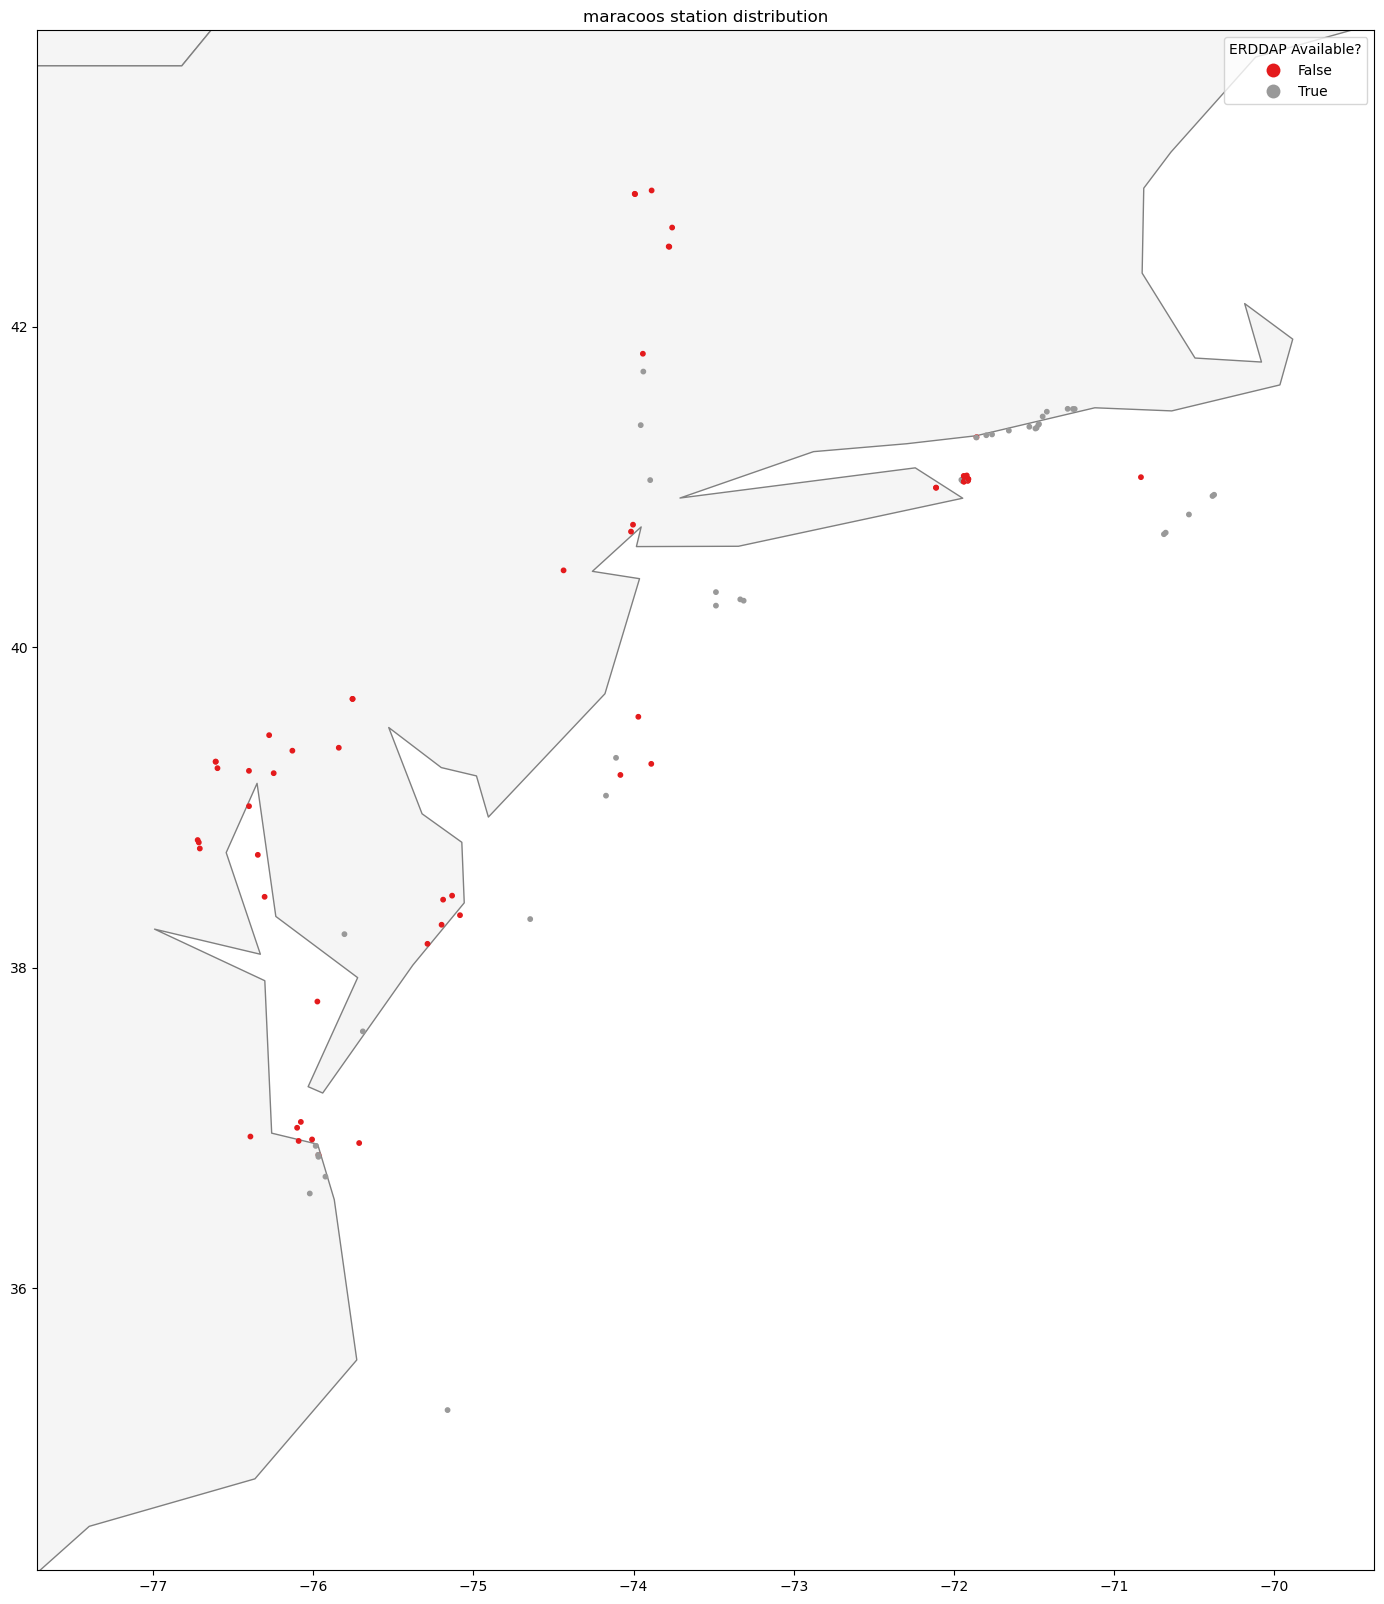

In [18]:
import geopandas
import matplotlib.pyplot as plt

#df = df.loc[df['']]

df.rename(columns=
{'Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].':
     'Variable Names',
 'Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)': 'Station Deployment',
 'Longitude (dec deg)': 'Longitude',
 'Latitude (dec deg)': 'Latitude'},
              inplace=True)

df['Station Deployment'] = \
    df['Station Deployment'].astype(str)


gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df['Longitude'], df['Latitude']))

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = world.plot(
    color='whitesmoke', 
    edgecolor='grey', 
    figsize=(25,20),
    )

gdf.plot( ax=ax,
         column='erddap_avail', 
         categorical=True, 
         cmap = 'Set1',
         markersize=10, 
         legend=True,
         legend_kwds={'title': "ERDDAP Available?"},
         k=2,
        )



minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx-1, maxx+1)
ax.set_ylim(miny-1, maxy+1)

plt.title('{} station distribution'.format(ra))

plt.show()

Make an interactive map.

When you click on a point the return is the information from the inventory.

In [19]:
gdf_final = gdf.set_crs(epsg=4326)

gdf_final.loc[~gdf_final['geometry'].is_empty == True].drop(columns='Variable Names').explore('erddap_avail',cmap = 'Set1', style_kwds={"radius":5})


## Show me some bad coordinates

_if there are any_

In [20]:
gdf_final.loc[gdf_final['geometry'].is_empty == True]

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude,Longitude,Platform Type,Station Deployment,"Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,Variable Names,Additional notes,geometry,erddap_avail


In [21]:
# import urllib.request
# for url in gdf_final.loc[gdf_final['erddap_not_avail'],'Station Description'].str.replace('url: ',''):
#     print(url)
#     try:
#         urllib.request.urlopen(url).getcode()
#     except:
#         print("URL broken: %s" % url)
#         print(gdf_final.loc[gdf_final['Station Description'].str.contains(url,regex=False),'Station ID'])

# Show me the stations where ERDDAP doesn't exist or provide a valid response.

Reasons:
* Station not found on RA erddap
* dataset found but no data for this CY.

In [22]:
gdf_final.loc[~gdf_final['erddap_avail']]

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude,Longitude,Platform Type,Station Deployment,"Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,Variable Names,Additional notes,geometry,erddap_avail
0,MARACOOS,Iron_Pot_Landing,N/A: No WMO numbers,Iron_Pot_Landing - Maryland DNR Station,Maryland Department of Natural Resources water...,38.796,-76.7208,fixed,2003,Y,Maryland DNR,N,Maryland DNR,gov_state,Maryland DNR,RPS-ASA,"Fractional_saturation_of_oxygen_in_sea_water, ...",NaN,POINT (-76.72080 38.79600),False
1,MARACOOS,Jug_Bay,N/A: No WMO numbers,Jug_Bay - Maryland DNR Station,Maryland Department of Natural Resources water...,38.7813,-76.7137,fixed,2003,Y,Maryland DNR,N,Maryland DNR,gov_state,Maryland DNR,RPS-ASA,"Fractional_saturation_of_oxygen_in_sea_water, ...",NaN,POINT (-76.71370 38.78130),False
2,MARACOOS,Mataponi,N/A: No WMO numbers,Mataponi - Maryland DNR Station,Maryland Department of Natural Resources water...,38.7433,-76.7074,fixed,2003,Y,Maryland DNR,N,Maryland DNR,gov_state,Maryland DNR,RPS-ASA,"Fractional_saturation_of_oxygen_in_sea_water, ...",NaN,POINT (-76.70740 38.74330),False
3,MARACOOS,Aquarium_West,N/A: No WMO numbers,Aquarium_West - Maryland DNR Station,Maryland Department of Natural Resources water...,39.2854,-76.6088,fixed,2016,Y,Maryland DNR,N,Maryland DNR,gov_state,Maryland DNR,RPS-ASA,"Fractional_saturation_of_oxygen_in_sea_water, ...",NaN,POINT (-76.60880 39.28540),False
4,MARACOOS,Aquarium_East,N/A: No WMO numbers,Aquarium_East - Maryland DNR Station,Maryland Department of Natural Resources water...,39.2855,-76.608,fixed,2016,Y,Maryland DNR,N,Maryland DNR,gov_state,Maryland DNR,RPS-ASA,"Fractional_saturation_of_oxygen_in_sea_water, ...",NaN,POINT (-76.60800 39.28550),False
5,MARACOOS,Pleasure_Island,N/A: No WMO numbers,Pleasure_Island - Maryland DNR Station,Maryland Department of Natural Resources water...,39.2282,-76.4006,fixed,2015,Y,Maryland DNR,N,Maryland DNR,gov_state,Maryland DNR,RPS-ASA,"Fractional_saturation_of_oxygen_in_sea_water, ...",NaN,POINT (-76.40060 39.22820),False
6,MARACOOS,Sandy_Pt_South_Beach,N/A: No WMO numbers,Sandy_Pt_South_Beach - Maryland DNR Station,Maryland Department of Natural Resources water...,39.0075,-76.4003,fixed,2004,Y,Maryland DNR,N,Maryland DNR,gov_state,Maryland DNR,RPS-ASA,"Fractional_saturation_of_oxygen_in_sea_water, ...",NaN,POINT (-76.40030 39.00750),False
7,MARACOOS,Tinghman_Island,N/A: No WMO numbers,Tinghman_Island - Maryland DNR Station,Maryland Department of Natural Resources water...,38.7037,-76.3453,fixed,2017,Y,Maryland DNR,N,Maryland DNR,gov_state,Maryland DNR,RPS-ASA,"Fractional_saturation_of_oxygen_in_sea_water, ...",NaN,POINT (-76.34530 38.70370),False
8,MARACOOS,Taylors_Island,N/A: No WMO numbers,Taylors Island - Maryland DNR Station,Maryland Department of Natural Resources water...,38.4418,-76.3029,fixed,2017,Y,Maryland DNR,N,Maryland DNR,gov_state,Maryland DNR,RPS-ASA,"Fractional_saturation_of_oxygen_in_sea_water, ...",NaN,POINT (-76.30290 38.44180),False
9,MARACOOS,Otter_Point_Creek,N/A: No WMO numbers,Otter_Point_Creek - Maryland DNR Station,Maryland Department of Natural Resources water...,39.4508,-76.2746,fixed,2003,Y,Maryland DNR,N,Maryland DNR,gov_state,Maryland DNR,RPS-ASA,"Fractional_saturation_of_oxygen_in_sea_water, ...",NaN,POINT (-76.27460 39.45080),False


# Do some checking against the IOOS catalog

only for datasets that we couldn't find in ERDDAP (per above)

In [23]:
from ckanapi import RemoteCKAN
import xarray as xr

problem_datasets = []

ua = 'ckanapiioos/1.0 (+https://ioos.us/)'

#ioos_catalog = RemoteCKAN('https://data.ioos.us', user_agent=ua, get_only=True)
ioos_catalog = RemoteCKAN('https://data.ioos.us', user_agent=ua)
ioos_catalog

gdf_ckan = gdf_final.loc[~gdf_final['erddap_avail']]

for station in gdf_ckan['Station ID'].dropna():

    RA = gdf_ckan.loc[gdf_ckan['Station ID']==station,'RA'].tolist()[0]
    
    print('Station "{}" + RA "{}"'.format(station.lower(), RA.lower()))
    
    # build RA tag query
    fq = '+organization:{}'.format(RA.lower())

    # build free text query
    q = "\""+station.lower()+"\""+" -glider"

    query = ioos_catalog.address + '/dataset/?' + 'q=' + q + '&organization=' + RA.lower()
    
    print('Query: {}'.format(query.replace(" ","%20")))

    datasets = ioos_catalog.action.package_search(q=q, fq=fq)

    

    if datasets['count'] > 0:
        print('\tfound {} dataset(s):'.format(datasets['count']))
        
        for dataset in datasets['results']:
            print('\t',dataset['title'])
            
            
            if dataset['resources']:
                print('\t',dataset['resources'][0]['url'])

                start_date = next(item for item in dataset["extras"] if item["key"] == "temporal-extent-begin")['value']
                end_date = next(item for item in dataset["extras"] if item["key"] == "temporal-extent-end")['value']

                print('\t','Coverage Meta:\n\t\t', start_date,' - ',end_date,'\n')

                if 'thredds' in dataset['resources'][0]['url']:
                    ds = xr.open_dataset(dataset['resources'][0]['url'])

                    time_max = ds.time.max().values

                    time_min = ds.time.min().values


                    print('\tCoverage Data:\n\t\t', time_min,' - ',time_max, '\n')

                    if pd.to_datetime(end_date) < pd.to_datetime(time_max, utc=True):
                        test_date = pd.to_datetime(time_max, utc=True)

                else:
                    test_date = pd.to_datetime(end_date, utc=True)

                if test_date > pd.to_datetime('{}-01-01'.format(cy), utc=True):
                    print('\t{} is valid.'.format(station))
                    break
                else:
                    print('\t{} is not valid.'.format(station))

                    problem_datasets.append(station)
            
            else:
                print('\t{} missing additional metadata'.format(station))
                problem_datasets.append(station)
    else:
        print("\tNo datasets found!")
        problem_datasets.append(station)

Station "iron_pot_landing" + RA "maracoos"
Query: https://data.ioos.us/dataset/?q="iron_pot_landing"%20-glider&organization=maracoos
	found 1 dataset(s):
	 MDDNR, Station Iron Pot Landing
	 https://erddap.maracoos.org/erddap/tabledap/mddnr_Iron_Pot_Landing
	 Coverage Meta:
		 2017-04-01T00:00:26Z  -  2019-10-08T15:30:00Z 

	Iron_Pot_Landing is not valid.
Station "jug_bay" + RA "maracoos"
Query: https://data.ioos.us/dataset/?q="jug_bay"%20-glider&organization=maracoos
	found 1 dataset(s):
	 MDDNR, Station Jug Bay
	 https://erddap.maracoos.org/erddap/tabledap/mddnr_Jug_Bay
	 Coverage Meta:
		 2017-04-01T00:00:25Z  -  2025-03-03T22:30:00Z 

	Jug_Bay is valid.
Station "mataponi" + RA "maracoos"
Query: https://data.ioos.us/dataset/?q="mataponi"%20-glider&organization=maracoos
	found 1 dataset(s):
	 MDDNR, Station Mataponi
	 https://erddap.maracoos.org/erddap/tabledap/mddnr_Mataponi
	 Coverage Meta:
		 2017-04-12T16:00:13Z  -  2019-10-08T14:30:00Z 

	Mataponi is not valid.
Station "aquarium_

Check the datasets that didn't have coverage in ERDDAP or through IOOS catalog and see if they are **Currently Operational?**

In [24]:
gdf_ckan.loc[gdf_ckan['Station ID'].isin(problem_datasets)]

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude,Longitude,Platform Type,Station Deployment,"Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,Variable Names,Additional notes,geometry,erddap_avail
0,MARACOOS,Iron_Pot_Landing,N/A: No WMO numbers,Iron_Pot_Landing - Maryland DNR Station,Maryland Department of Natural Resources water...,38.796,-76.7208,fixed,2003,Y,Maryland DNR,N,Maryland DNR,gov_state,Maryland DNR,RPS-ASA,"Fractional_saturation_of_oxygen_in_sea_water, ...",NaN,POINT (-76.72080 38.79600),False
2,MARACOOS,Mataponi,N/A: No WMO numbers,Mataponi - Maryland DNR Station,Maryland Department of Natural Resources water...,38.7433,-76.7074,fixed,2003,Y,Maryland DNR,N,Maryland DNR,gov_state,Maryland DNR,RPS-ASA,"Fractional_saturation_of_oxygen_in_sea_water, ...",NaN,POINT (-76.70740 38.74330),False
5,MARACOOS,Pleasure_Island,N/A: No WMO numbers,Pleasure_Island - Maryland DNR Station,Maryland Department of Natural Resources water...,39.2282,-76.4006,fixed,2015,Y,Maryland DNR,N,Maryland DNR,gov_state,Maryland DNR,RPS-ASA,"Fractional_saturation_of_oxygen_in_sea_water, ...",NaN,POINT (-76.40060 39.22820),False
6,MARACOOS,Sandy_Pt_South_Beach,N/A: No WMO numbers,Sandy_Pt_South_Beach - Maryland DNR Station,Maryland Department of Natural Resources water...,39.0075,-76.4003,fixed,2004,Y,Maryland DNR,N,Maryland DNR,gov_state,Maryland DNR,RPS-ASA,"Fractional_saturation_of_oxygen_in_sea_water, ...",NaN,POINT (-76.40030 39.00750),False
7,MARACOOS,Tinghman_Island,N/A: No WMO numbers,Tinghman_Island - Maryland DNR Station,Maryland Department of Natural Resources water...,38.7037,-76.3453,fixed,2017,Y,Maryland DNR,N,Maryland DNR,gov_state,Maryland DNR,RPS-ASA,"Fractional_saturation_of_oxygen_in_sea_water, ...",NaN,POINT (-76.34530 38.70370),False
8,MARACOOS,Taylors_Island,N/A: No WMO numbers,Taylors Island - Maryland DNR Station,Maryland Department of Natural Resources water...,38.4418,-76.3029,fixed,2017,Y,Maryland DNR,N,Maryland DNR,gov_state,Maryland DNR,RPS-ASA,"Fractional_saturation_of_oxygen_in_sea_water, ...",NaN,POINT (-76.30290 38.44180),False
10,MARACOOS,Tolchester,N/A: No WMO numbers,Tolchester - Maryland DNR Station,Maryland Department of Natural Resources water...,39.2135,-76.2462,fixed,2015,Y,Maryland DNR,N,Maryland DNR,gov_state,Maryland DNR,RPS-ASA,"Fractional_saturation_of_oxygen_in_sea_water, ...",NaN,POINT (-76.24620 39.21350),False
11,MARACOOS,Camp_Tockwogh,N/A: No WMO numbers,Camp_Tockwogh - Maryland DNR Station,Maryland Department of Natural Resources water...,39.3539,-76.1296,fixed,2015,Y,Maryland DNR,N,Maryland DNR,gov_state,Maryland DNR,RPS-ASA,"Fractional_saturation_of_oxygen_in_sea_water, ...",NaN,POINT (-76.12960 39.35390),False
12,MARACOOS,Budds_Landing,N/A: No WMO numbers,Budds_Landing - Maryland DNR Station,Maryland Department of Natural Resources water...,39.3723,-75.8399,fixed,2007,Y,Maryland DNR,N,Maryland DNR,gov_state,Maryland DNR,RPS-ASA,"Fractional_saturation_of_oxygen_in_sea_water, ...",NaN,POINT (-75.83990 39.37230),False
14,MARACOOS,UD 3.7M GEO DISH,N/A: No WMO numbers,UDel Geostationary Satellite ground Station,Geostationary Satellite Ground Station,39.677,-75.754,fixed_satellite,2013,Y,"MARACOOS, Udelaware",Yp,Univ. Delaware,ACADEMIC,Univ. Delaware,RPS-ASA,All Standard GOES products,NaN,POINT (-75.75400 39.67700),False


Print out the available metadata from the IOOS Catalog for the last dataset.

In [25]:
dataset

{'author': None,
 'author_email': None,
 'creator_user_id': '0ea3933c-4674-41dd-a17d-bfbc8c99bd75',
 'id': 'c79b02d4-1fdd-4667-a20a-570527daa748',
 'isopen': False,
 'license_id': None,
 'license_title': None,
 'maintainer': None,
 'maintainer_email': None,
 'metadata_created': '2024-08-22T04:22:59.263718',
 'metadata_modified': '2025-03-07T12:37:07.902314',
 'name': 'atlantic-shores-offshore-wind-asow-1-winds-profile',
 'notes': 'AtlanticShores. This dataset contains observations to support scientific research of the mid-Atlantic cold pool and to further understanding of metocean conditions off the coast of New Jersey.  Data is collected from a floating lidar buoy and the dataset includes measurements of sea temperature (surface and sea floor), current speed, current direction, wave, air temperature, atmospheric pressure, relative humidity, surface wind speed, surface wind direction, and wind speed and wind direction between 10m to 200m.',
 'num_resources': 6,
 'num_tags': 41,
 'organ

In [26]:
# GLOS special case as they provide ERDDAP ID

# for dataset in gdf_final.loc[(~gdf_final['erddap_avail'] & ~gdf_final['Dataset (ERDDAP) ID'].isna()),'Dataset (ERDDAP) ID'].tolist():
#     print(dataset)
#     e.dataset_id = dataset
    
#     e.constraints = {
#                  "time>=": "{}-01-01".format(cy)
#             }
        
#     e.variables = ['time']
    
#     try:
        
#         df_data = e.to_pandas(parse_dates=True)
        
#         string = '\tDate range: {} - {}'.format(df_data.min()[0],df_data.max()[0])
        
#         print(string)
        
#         if pd.to_datetime(df_data.max()[0], utc=True) > pd.to_datetime('{}-01-01'.format(cy), utc=True):
            
#             datasetid = gdf_final.loc[gdf_final['Dataset (ERDDAP) ID']==dataset,'Station ID'].tolist()[0]
            
#             problem_datasets.remove(datasetid)
        
#     except:
#         print('\tNo valid data')

In [27]:
#gdf_ckan.loc[gdf_ckan['Station ID'].isin(problem_datasets)]